In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# FFT synthetic data
---

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack as fft
import seaborn as sns
import torch

from omegaconf import OmegaConf
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from data._main import get_dataset
from utils import NEURONS_302


In [64]:
dataset = get_dataset(
    OmegaConf.create({"dataset": {"name": "Kato2015", "leave_out_worms": []}})
)

Chosen dataset(s): ['Kato2015']
Num. worms: 12



In [65]:
for wormID, data in dataset.items():
    print(
        wormID,
        len([idx for idx in data["slot_to_named_neuron"].keys()]),
        data["calcium_data"].shape[0],
    )

worm0 43 2879
worm1 44 2879
worm2 37 2879
worm3 51 2879
worm4 45 2879
worm5 44 2879
worm6 51 2879
worm7 38 4319
worm8 44 4319
worm9 32 4319
worm10 47 4319
worm11 31 4319


In [66]:
def compute_R2(y_observed, y_predicted):
    # Calculate the mean of the observed data points
    mean_y = np.mean(y_observed)

    # Calculate the total sum of squares (TSS)
    tss = np.sum((y_observed - mean_y) ** 2)

    # Calculate the residual sum of squares (RSS)
    rss = np.sum((y_observed - y_predicted) ** 2)

    # Compute R-squared
    r_squared = 1 - (rss / tss)

    return r_squared


def approximate_exponential_decay(single_worm_dataset):
    # Define the function to fit
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    # Define the function to fit
    def rational_func(x, a, b, c):
        return a * 1 / x**b + c

    calcium = single_worm_dataset["calcium_data"]
    mask = single_worm_dataset["named_neurons_mask"]
    dt = single_worm_dataset["resample_median_dt"]

    data = calcium[:, mask]

    fft_data = torch.fft.rfft(data, dim=0)  # only the real part
    fft_freqs = torch.fft.rfftfreq(data.size(0), d=dt)  # only the positive frequencies

    # Convert fft_data and fft_freqs to numpy for use with curve_fit
    fft_data_np = fft_data.detach().numpy()
    fft_freqs_np = fft_freqs.detach().numpy()

    # Power spectrum
    magnitude_spectrum = np.abs(fft_data_np)

    # Phase spectrum
    phase_spectrum = np.angle(fft_data_np)

    # Fit function to each column of data in the power spectrum
    num_neurons = fft_data_np.shape[1]
    fit_params = np.zeros((num_neurons, 3))  # for a, b, and c
    fit_quality = np.zeros(num_neurons)  # for storing the quality of fit

    for i in range(num_neurons):
        try:
            popt, pcov = curve_fit(func, fft_freqs_np, magnitude_spectrum[:, i])
        except RuntimeError:
            print("Error - curve_fit failed")
            continue
        fit_params[i, :] = popt  # each row is a, b, and c for a neuron
        # fit_quality[i] = np.sum((magnitude_spectrum[:, i] - func(fft_freqs_np, *popt)) ** 2) # calculate RSS
        # fit_quality[i] = np.sqrt(fit_quality[i]/len(magnitude_spectrum[:, i])-2) # calculate RSE
        fit_quality[i] = compute_R2(
            magnitude_spectrum[:, i], func(fft_freqs_np, *popt)
        )  # calculate R2

    # Generate x values
    f = np.linspace(fft_freqs_np.min(), fft_freqs_np.max(), num=fft_freqs_np.size)

    # Plot each fitted curve
    exponential_fits = np.zeros_like(fft_data_np)

    for i in range(num_neurons):
        # Generate y values for this curve
        exponential_fits[:, i] = func(f, *fit_params[i])

    return (
        fft_freqs_np,
        magnitude_spectrum,
        phase_spectrum,
        exponential_fits,
        fit_params,
        fit_quality,
    )

In [67]:
(
    fft_freqs_np,
    magnitude_spectrum,
    phase_spectrum,
    exponential_fits,
    fit_params,
    fit_quality,
) = approximate_exponential_decay(dataset["worm0"])

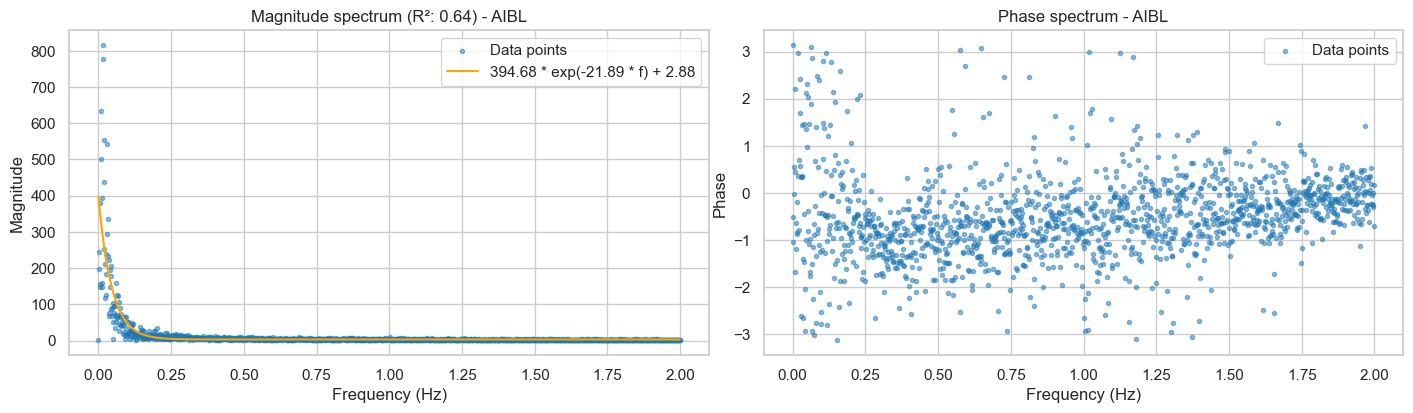

In [68]:
idx = 0
neuron_idx = np.where(dataset["worm0"]["named_neurons_mask"] == True)[0][idx]

# Use whitegrid style from sns
sns.set(style="whitegrid")
# Use tab10 palette
sns.set_palette("tab10")

# Subplot the power spectrum and the phases
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].scatter(
    fft_freqs_np[:],
    magnitude_spectrum[:, idx],
    marker=".",
    label="Data points",
    alpha=0.5,
)
fit_label = "{} * exp(-{} * f) + {}".format(
    round(fit_params[idx, 0], 2),
    round(fit_params[idx, 1], 2),
    round(fit_params[idx, 2], 2),
)
axs[0].plot(fft_freqs_np[:], exponential_fits[:, idx], color="orange", label=fit_label)
axs[0].set_title(
    "Magnitude spectrum (R²: {}) - {}".format(
        round(fit_quality[idx], 2), dataset["worm0"]["slot_to_named_neuron"][neuron_idx]
    )
)
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude")
axs[0].legend()

axs[1].scatter(
    fft_freqs_np[:], phase_spectrum[:, idx], marker=".", label="Data points", alpha=0.5
)
axs[1].set_title(
    "Phase spectrum - {}".format(dataset["worm0"]["slot_to_named_neuron"][neuron_idx])
)
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Phase")
axs[1].legend()
plt.tight_layout(pad=0.2)
plt.show()

In [69]:
import numpy as np
import scipy.fftpack as fft


def synthesize_time_series(exponential_fits, time_steps, random_seed=42):
    """Create a synthetic time series given a power spectrum."""
    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    num_freqs = exponential_fits.shape[0]
    synthetic_data = np.zeros((time_steps, exponential_fits.shape[1]))

    for i in range(synthetic_data.shape[1]):
        # Generate a random phase spectrum
        phase_spectrum = np.random.normal(
            0.0, 1.8, num_freqs
        )  # let's fix sigma to 1.8 for now
        # Combine the power and phase spectra
        freq_domain_signal = exponential_fits[:, i] * np.exp(1j * phase_spectrum)
        # Perform the inverse Fourier transform to get the time series
        synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps).real

    return synthetic_data

In [70]:
synthetic_data = synthesize_time_series(
    exponential_fits, dataset["worm0"]["calcium_data"].shape[0], random_seed=42
)

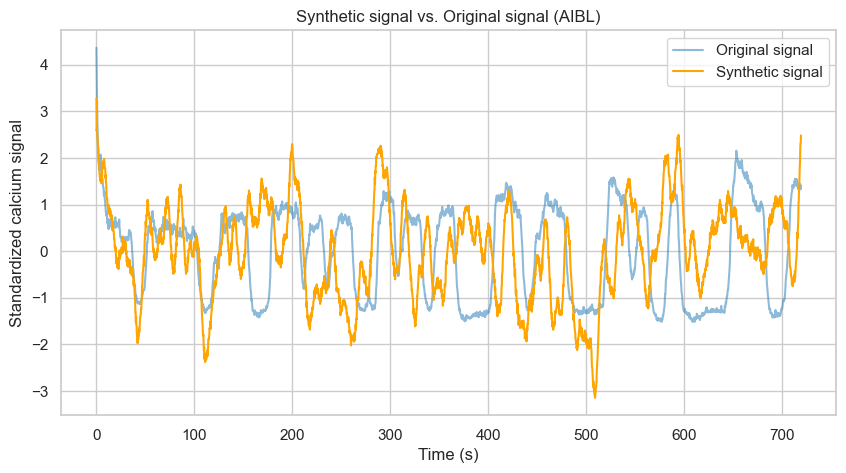

In [71]:
# Scale the synthetic data and original data with min_max scaling along dimension 0
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
synthetic_data = scaler.fit_transform(synthetic_data)
dataset["worm0"]["calcium_data"] = scaler.fit_transform(
    dataset["worm0"]["calcium_data"]
)

calcium_data = dataset["worm0"]["calcium_data"]
mask = dataset["worm0"]["named_neurons_mask"]
data = calcium_data[:, mask]

time_steps = data.shape[0]
time_vec = np.arange(time_steps) * 0.25

# Use whitegrid style from sns
sns.set(style="whitegrid")
# Use tab10 palette
sns.set_palette("tab10")

# Plot the synthetic data and original data
idx = 0
neuron_idx = np.where(dataset["worm0"]["named_neurons_mask"] == True)[0][idx]
plt.figure(figsize=(10, 5))
plt.plot(time_vec, data[:, idx], label="Original signal", alpha=0.5)
plt.plot(time_vec, synthetic_data[:, idx], color="orange", label="Synthetic signal")
plt.legend()
plt.title(
    "Synthetic signal vs. Original signal ({})".format(
        dataset["worm0"]["slot_to_named_neuron"][neuron_idx]
    )
)
plt.xlabel("Time (s)")
plt.ylabel("Standardized calcium signal")
plt.grid(True)

plt.show()

In [72]:
# Pipeline for phase distribution: compute the mean of the phases for each neuron of every individual


def distribution_params():
    dataset_names = [
        "Flavell2023",
        "Kato2015",
        "Nichols2017",
        "Skora2018",
        "Uzel2022",
        "Kaplan2020",
    ]  # Leifer2023 - 103 worms

    phases = np.zeros((143, 302, 2))  # (individual, neuron, (mu, std))
    exp_decay_params = np.zeros((143 + 103, 302, 3))  # (individual, neuron, (a, b, c))

    worm_count = 0

    for ds_name in dataset_names:
        # Load a single dataset
        dataset = get_dataset(
            OmegaConf.create({"dataset": {"name": ds_name, "leave_out_worms": []}})
        )

        # Iterate over worms in the dataset
        for wormid, data in dataset.items():
            (
                fft_freqs_np,
                magnitude_spectrum,
                phase_spectrum,
                exponential_fits,
                fit_params,
                fit_quality,
            ) = approximate_exponential_decay(data)

            if (not fit_params is None) and (not phase_spectrum is None):
                for i, named_neuron in enumerate(data["slot_to_named_neuron"]):
                    phases[worm_count, named_neuron, 0] = np.mean(
                        phase_spectrum[:, i]
                    )  # mu
                    phases[worm_count, named_neuron, 1] = np.std(
                        phase_spectrum[:, i]
                    )  # std

                    exp_decay_params[worm_count, named_neuron, 0] = fit_params[
                        i, 0
                    ]  # a
                    exp_decay_params[worm_count, named_neuron, 1] = fit_params[
                        i, 1
                    ]  # b
                    exp_decay_params[worm_count, named_neuron, 2] = fit_params[
                        i, 2
                    ]  # c

            worm_count += 1

    return phases, exp_decay_params

In [73]:
from scipy.stats import bootstrap
from scipy.stats import norm


def bootstrap_mean(
    data_array, confidence_level=0.9, random_state=None, ax=None, title=None
):
    """Computes the bootstrap mean distribution of the given data.

    Parameters
    ----------
    data_array : array_like (1D)
        Input data. Samples must be in a sequence.
    confidence_level : float, optional
        Confidence level of the bootstrap distribution. Must be between 0 and 1.
    random_state : int, RandomState instance or None, optional
        Seed for the random number generator (if int), or numpy RandomState instance.

    Returns
    -------
    np.mean(res.bootstrap_distribution) : float
        Mean of the bootstrap distribution.
    res.standard_error : float
        Standard error of the bootstrap distribution.
    res.confidence_interval : tuple
        Confidence interval of the bootstrap distribution.
    """

    data = (data_array,)  # samples must be in a sequence
    rng = np.random.default_rng(random_state)
    res = bootstrap(data, np.mean, confidence_level=0.9, random_state=rng)

    if ax is not None:
        ax.hist(res.bootstrap_distribution, bins=25, density=True, alpha=0.75)
        ax.set_title("Bootstrap Mean Distribution (a coefficient)")
        ax.set_xlabel("Mean")
        ax.set_ylabel("PDF")

        # Draw vertical line on the mean
        ax.axvline(
            np.mean(res.bootstrap_distribution),
            color="black",
            linestyle="-.",
            alpha=0.5,
        )

        # Plot a gaussian with mean and std of the bootstrap distribution
        x = np.linspace(
            min(res.bootstrap_distribution),
            max(res.bootstrap_distribution),
            len(res.bootstrap_distribution),
        )
        y = norm.pdf(
            x, loc=np.mean(res.bootstrap_distribution), scale=res.standard_error
        )
        ax.plot(x, y, linestyle="-")

        # Shade inside the confidence intervals
        ax.fill_between(
            x,
            y,
            where=(x > res.confidence_interval[0]) & (x < res.confidence_interval[1]),
            alpha=0.5,
        )

        # Shade outside the confidence intervals
        ax.fill_between(
            x,
            y,
            where=(x < res.confidence_interval[0]) | (x > res.confidence_interval[1]),
            alpha=0.5,
        )

        if title is not None:
            ax.set_title(title)

        plt.tight_layout(pad=0.5)
        plt.grid(True)
        sns.set_style("whitegrid")

    return (
        np.mean(res.bootstrap_distribution),
        res.standard_error,
        res.confidence_interval,
    )

## Neuron phase signature
---

There's no evident relation between the phases and the frequency

In [74]:
phases, exp_decay_params = distribution_params()


Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Chosen dataset(s): ['Kato2015']
Num. worms: 12

Chosen dataset(s): ['Nichols2017']
Num. worms: 44

Chosen dataset(s): ['Skora2018']
Num. worms: 12

Chosen dataset(s): ['Uzel2022']
Num. worms: 6

Chosen dataset(s): ['Kaplan2020']
Num. worms: 19



In [75]:
from scipy.stats import shapiro

test_counter = 0
gdist = 0

for i in range(302):
    neuron_phase_mean = phases[:, i, 0]  # mu
    mask = np.where(neuron_phase_mean != 0)[0]
    data_to_test = neuron_phase_mean[mask]

    # Test normality of the mean phase distribution
    if len(data_to_test) > 3:
        stat, p = shapiro(data_to_test)
        test_counter += 1
        # print('Shapiro-Wilk test for normality for neuron {}: {}'.format(i, p>0.05)) # True if normal dist
        if p > 0.05:
            gdist += 1

print(gdist / test_counter)

0.5577889447236181


We don't have enough information to reject the hypothesis that the mean phase of 65% of the neurons follow a gaussian distribution!

=> hypothesis: all mean neuron phases can be approximated by a Gaussian distribution.

In [76]:
log = open("log.txt", "w")

phase_signature = np.zeros((2, len(NEURONS_302)))  # (neuron, (mu, std))

count_neurons_with_no_values = 0

for i, neuron_name in enumerate(NEURONS_302):
    mask = np.where(phases[:, i, 0] != 0)[0]
    neuron_phases_mean = phases[:, i, 0][mask]  # mu
    neuron_phases_std = phases[:, i, 1][mask]  # std

    if np.sum(neuron_phases_mean) == 0:
        # Write in the log the neurons with no values
        log.write("Neuron {} has no values\n".format(neuron_name))
        count_neurons_with_no_values += 1

    else:
        if len(neuron_phases_mean) <= 1 or len(neuron_phases_std) <= 1:
            # Write in the log the neurons with only one value
            log.write("Neuron {} has only one value\n".format(neuron_name))
            continue
        phase_signature[0, i], _, _ = bootstrap_mean(neuron_phases_mean)  # mean, std
        phase_signature[1, i], _, _ = bootstrap_mean(neuron_phases_std)  # mean, std

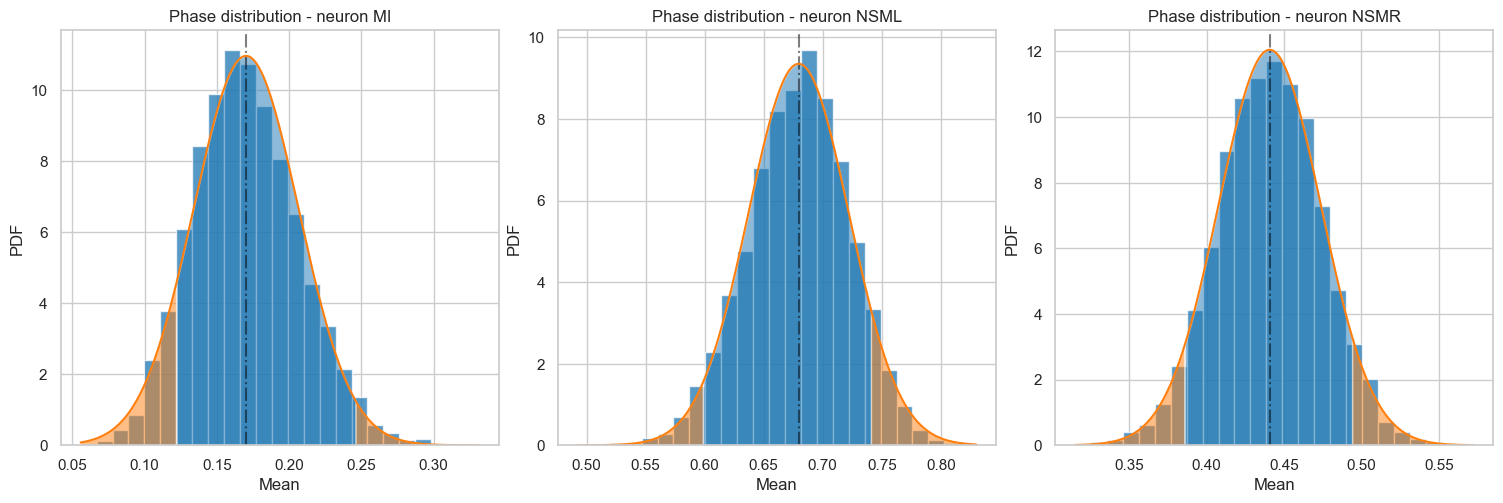

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

neuron_idx1, neuron_idx2, neuron_idx3 = 148, 149, 150

mask1 = np.where(phases[:, neuron_idx1, 0] != 0)[0]  # neuron missing values mask
mask2 = np.where(phases[:, neuron_idx2, 0] != 0)[0]  # neuron missing values mask
mask3 = np.where(phases[:, neuron_idx3, 0] != 0)[0]  # neuron missing values mask

phase1 = phases[:, neuron_idx1, 0][mask1]
phase2 = phases[:, neuron_idx2, 0][mask2]
phase3 = phases[:, neuron_idx3, 0][mask3]

_ = bootstrap_mean(
    phase1,
    ax=axs[0],
    title="Phase distribution - neuron {}".format(NEURONS_302[neuron_idx1]),
)
_ = bootstrap_mean(
    phase2,
    ax=axs[1],
    title="Phase distribution - neuron {}".format(NEURONS_302[neuron_idx2]),
)
_ = bootstrap_mean(
    phase3,
    ax=axs[2],
    title="Phase distribution - neuron {}".format(NEURONS_302[neuron_idx3]),
)

In [78]:
# Save the phase signature
np.save("phase_signature.npy", phase_signature)

## Neuron (a, b, c) coefficients signature
---

In [79]:
_, exp_decay_params = distribution_params()


Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Chosen dataset(s): ['Kato2015']
Num. worms: 12

Chosen dataset(s): ['Nichols2017']
Num. worms: 44

Chosen dataset(s): ['Skora2018']
Num. worms: 12

Chosen dataset(s): ['Uzel2022']
Num. worms: 6

Chosen dataset(s): ['Kaplan2020']
Num. worms: 19



In [80]:
# Create a log to save the prints when the neuron has no values
log = open("log.txt", "w")

count_neurons_with_no_values = 0

a_coeffs = np.zeros((2, len(NEURONS_302)))
b_coeffs = np.zeros((2, len(NEURONS_302)))
c_coeffs = np.zeros((2, len(NEURONS_302)))

for i, neuron_name in enumerate(NEURONS_302):
    mask = np.where(exp_decay_params[:, i, 0] != 0)[0]  # neuron missing values mask
    a_coeff = exp_decay_params[:, i, 0][mask]
    b_coeff = exp_decay_params[:, i, 1][mask]
    c_coeff = exp_decay_params[:, i, 2][mask]

    if np.sum(exp_decay_params[:, i, 0][mask]) == 0:
        # Write in the log the neurons with no values
        log.write("Neuron {} has no values\n".format(neuron_name))
        count_neurons_with_no_values += 1
    else:
        if len(a_coeff) <= 1 or len(b_coeff) <= 1 or len(c_coeff) <= 1:
            # Write in the log the neurons with only one value
            log.write("Neuron {} has only one value\n".format(neuron_name))
            continue
        a_coeffs[0, i], a_coeffs[1, i], _ = bootstrap_mean(a_coeff)  # mean, std
        b_coeffs[0, i], b_coeffs[1, i], _ = bootstrap_mean(b_coeff)  # mean, std
        c_coeffs[0, i], c_coeffs[1, i], _ = bootstrap_mean(c_coeff)  # mean, std

In [81]:
# Save coefficients
np.save("a_coeffs.npy", a_coeffs)
np.save("b_coeffs.npy", b_coeffs)
np.save("c_coeffs.npy", c_coeffs)

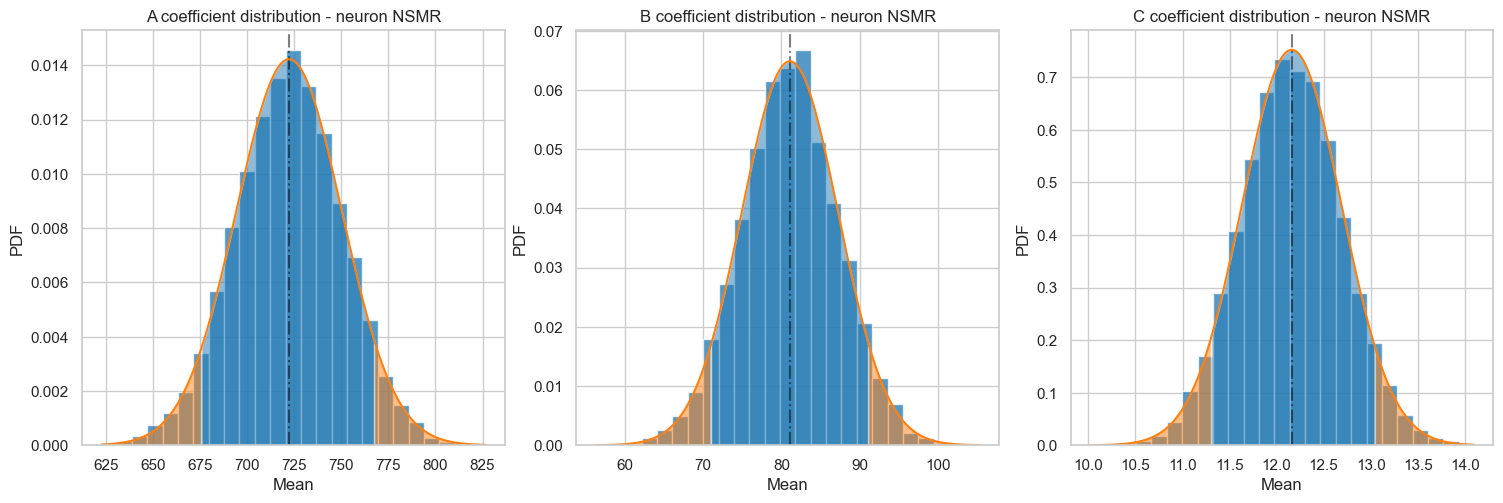

In [82]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

neuron_idx = 150
mask = np.where(exp_decay_params[:, neuron_idx, 0] != 0)[
    0
]  # neuron missing values mask
a_coeff = exp_decay_params[:, neuron_idx, 0][mask]
b_coeff = exp_decay_params[:, neuron_idx, 1][mask]
c_coeff = exp_decay_params[:, neuron_idx, 2][mask]

_ = bootstrap_mean(
    a_coeff,
    ax=axs[0],
    title="A coefficient distribution - neuron {}".format(NEURONS_302[neuron_idx]),
)
_ = bootstrap_mean(
    b_coeff,
    ax=axs[1],
    title="B coefficient distribution - neuron {}".format(NEURONS_302[neuron_idx]),
)
_ = bootstrap_mean(
    c_coeff,
    ax=axs[2],
    title="C coefficient distribution - neuron {}".format(NEURONS_302[neuron_idx]),
)

## Dataset
---

In [83]:
def synthesize_neural_activity(time_steps, dt, random_seed=42):
    """Create a synthetic time series given a magnitude/phase neuron signature."""

    # Decaying exp func
    def decaying_exp(x, a, b, c):
        return a * np.exp(-b * x) + c

    # Set a random seed for reproducibility, if provided
    if random_seed is not None:
        np.random.seed(random_seed)

    nyquist_freq = 1 / (2 * dt)
    freq_step = 1 / (time_steps * dt)
    frequencies = np.arange(0, nyquist_freq, freq_step)

    # Load magnitude spectrum parameters
    a_coeffs = np.load("a_coeffs.npy")
    b_coeffs = np.load("b_coeffs.npy")
    c_coeffs = np.load("c_coeffs.npy")

    # Load phase spectrum parameters
    phases = np.load("phase_signature.npy")

    # Store the synthetic data
    synthetic_data = np.zeros((time_steps, len(NEURONS_302)))

    # Store spectrums
    synthetic_magnitude_spectrum = np.zeros((len(frequencies), len(NEURONS_302)))
    synthetic_phase_spectrum = np.zeros((len(frequencies), len(NEURONS_302)))

    for i, neuron_name in enumerate(NEURONS_302):
        if a_coeffs[0, i] == 0.0:
            # We don't have the signature of this neuron
            continue

        else:
            # Sample a, b, c from a normal distribution
            a = np.random.normal(a_coeffs[0, i], a_coeffs[1, i], 1)
            b = np.random.normal(b_coeffs[0, i], b_coeffs[1, i], 1)
            c = np.random.normal(c_coeffs[0, i], c_coeffs[1, i], 1)

            # Generate the synthetic magnitude spectrum
            synthetic_magnitude_spectrum[:, i] = decaying_exp(frequencies, a, b, c)

            # Sample a phase from a normal distribution
            synthetic_phase_spectrum[:, i] = np.random.normal(
                phases[0, i], phases[1, i], len(frequencies)
            )

            # Clip the frequencies between -pi and pi
            synthetic_phase_spectrum[:, i] = np.clip(
                synthetic_phase_spectrum[:, i], -np.pi, np.pi
            )

            # Combine the power and phase spectra
            freq_domain_signal = synthetic_magnitude_spectrum[:, i] * np.exp(
                1j * synthetic_phase_spectrum[:, i]
            )

            # Perform the inverse Fourier transform to get the time series
            synthetic_data[:, i] = fft.ifft(freq_domain_signal, n=time_steps).real

    return (
        frequencies,
        synthetic_magnitude_spectrum,
        synthetic_phase_spectrum,
        synthetic_data,
    )

In [84]:
time_steps = 3000
dt = 0.25

(
    frequencies,
    synthetic_magnitude_spectrum,
    synthetic_phase_spectrum,
    synthetic_data,
) = synthesize_neural_activity(time_steps, dt, random_seed=42)

# Standard scale each column of the synthetic data
synthetic_data = StandardScaler().fit_transform(synthetic_data)

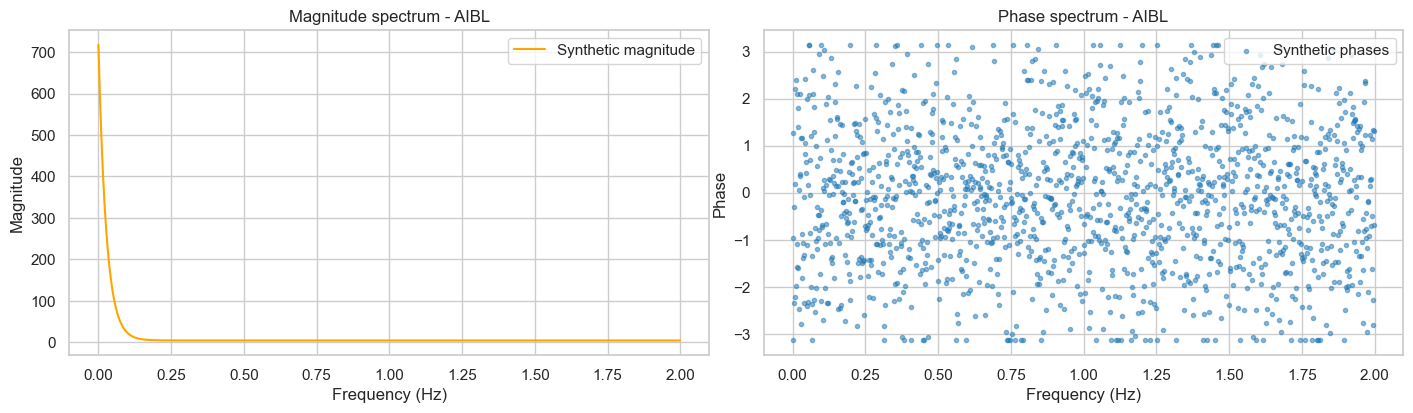

In [85]:
neuron_idx = 12

# Use whitegrid style from sns
sns.set(style="whitegrid")
# Use tab10 palette
sns.set_palette("tab10")

# Subplot the power spectrum and the phases
fig, axs = plt.subplots(1, 2, figsize=(14, 4))
axs[0].plot(
    frequencies,
    synthetic_magnitude_spectrum[:, neuron_idx],
    color="orange",
    label="Synthetic magnitude",
)
axs[0].set_title("Magnitude spectrum - {}".format(NEURONS_302[neuron_idx]))
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude")
axs[0].legend()

axs[1].scatter(
    frequencies,
    synthetic_phase_spectrum[:, neuron_idx],
    marker=".",
    label="Synthetic phases",
    alpha=0.5,
)
axs[1].set_title("Phase spectrum - {}".format(NEURONS_302[neuron_idx]))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Phase")
axs[1].legend()
plt.tight_layout(pad=0.2)
plt.show()

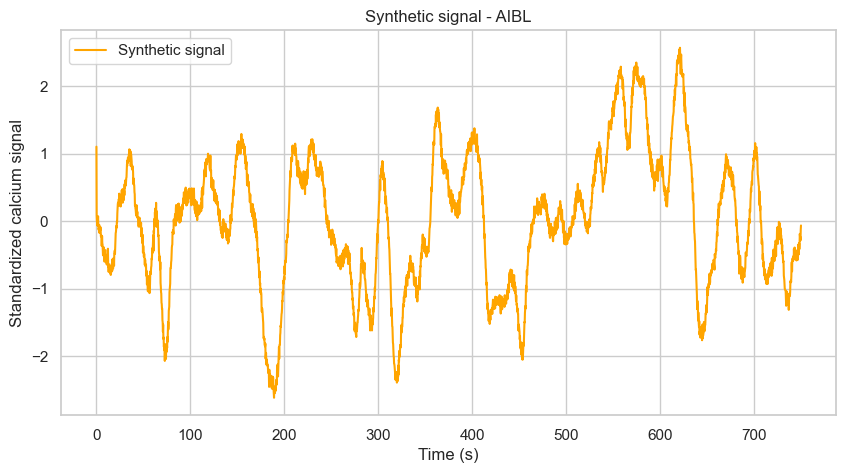

In [86]:
# Use whitegrid style from sns
sns.set(style="whitegrid")
# Use tab10 palette
sns.set_palette("tab10")

plt.figure(figsize=(10, 5))
plt.plot(
    np.arange(time_steps) * dt,
    synthetic_data[:, neuron_idx],
    color="orange",
    label="Synthetic signal",
)
plt.legend()
plt.title("Synthetic signal - {}".format(NEURONS_302[neuron_idx]))
plt.xlabel("Time (s)")
plt.ylabel("Standardized calcium signal")
plt.grid(True)

plt.show()

In [87]:
_, _, _, synthetic_data = synthesize_neural_activity(time_steps, dt, random_seed=42)
named_neurons_mask = synthetic_data[0, :] != 0

num_signals = 10

named_neurons_indices = np.random.choice(
    np.where(named_neurons_mask == True)[0], num_signals, replace=False
)

named_neurons = set(NEURONS_302[i] for i in named_neurons_indices)

# Create neuron to idx mapping and vice versa
neuron_to_idx = {
    (neuron) if neuron in named_neurons else str(idx): idx
    for idx, neuron in enumerate(NEURONS_302)
}
idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

In [88]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset_fft(
    max_timesteps,
    dt,
    random_seed=42,
    num_worms=1,
    num_named_neurons=[302],
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    assert (
        len(num_named_neurons) == num_worms
    ), "num_named_neurons must be the same length as num_worms"

    # Generate num_worms random seeds using the random_seed
    random_seeds = np.random.RandomState(random_seed).randint(0, 10000, num_worms)

    # Initialize the dataset
    dataset = {}

    # Create the time vector
    time_in_seconds = dt * np.arange(max_timesteps).reshape(-1, 1)

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Worm name
        worm = f"worm{worm_idx}"

        # Generate synthetic data
        freq, mag_spec, phase_spec, synthetic_data = synthesize_neural_activity(
            max_timesteps, dt, random_seed=random_seeds[worm_idx]
        )
        named_neurons_mask = synthetic_data[0, :] != 0

        num_signal = np.sum(named_neurons_mask)
        num_unknown_neurons = num_signal - num_named_neurons[worm_idx]

        # Verify the inputs
        assert num_named_neurons[worm_idx] <= np.sum(
            named_neurons_mask
        ), "We have neuron signature of only {} neurons. Pick a smaller number of named neurons.".format(
            np.sum(named_neurons_mask)
        )

        named_neurons_indices = np.random.choice(
            np.where(named_neurons_mask == True)[0],
            num_named_neurons[worm_idx],
            replace=False,
        )

        named_neurons = set(NEURONS_302[i] for i in named_neurons_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Normalize data
        calcium_data = transform.fit_transform(synthetic_data)

        # Smooth the data
        smooth_method = "GA"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )

        delta_t = np.gradient(time_in_seconds, axis=0)
        delta_t[delta_t == 0] = np.finfo(float).eps
        original_dt = np.median(delta_t).item()
        resample_dt = delta_t
        residual_calcium = np.gradient(calcium_data, axis=0) / delta_t
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data = {}
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = delta_t
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons[worm_idx]
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)

Kato:
worm0 43
worm1 44
worm2 37
worm3 51
worm4 45
worm5 44
worm6 51
worm7 38
worm8 44
worm9 32
worm10 47
worm11 31

In [90]:
# Creating and saving datasets
dataset = create_synthetic_dataset_fft(
    max_timesteps=2879,
    dt=0.25,
    random_seed=42,
    num_worms=12,
    num_named_neurons=[43, 44, 37, 51, 45, 44, 51, 38, 44, 32, 47, 31],
    transform=StandardScaler(),
    dataset_name="Synthetic_fft",
)
save_synthetic_dataset("processed/neural/Synthetic_fft.pickle", dataset)


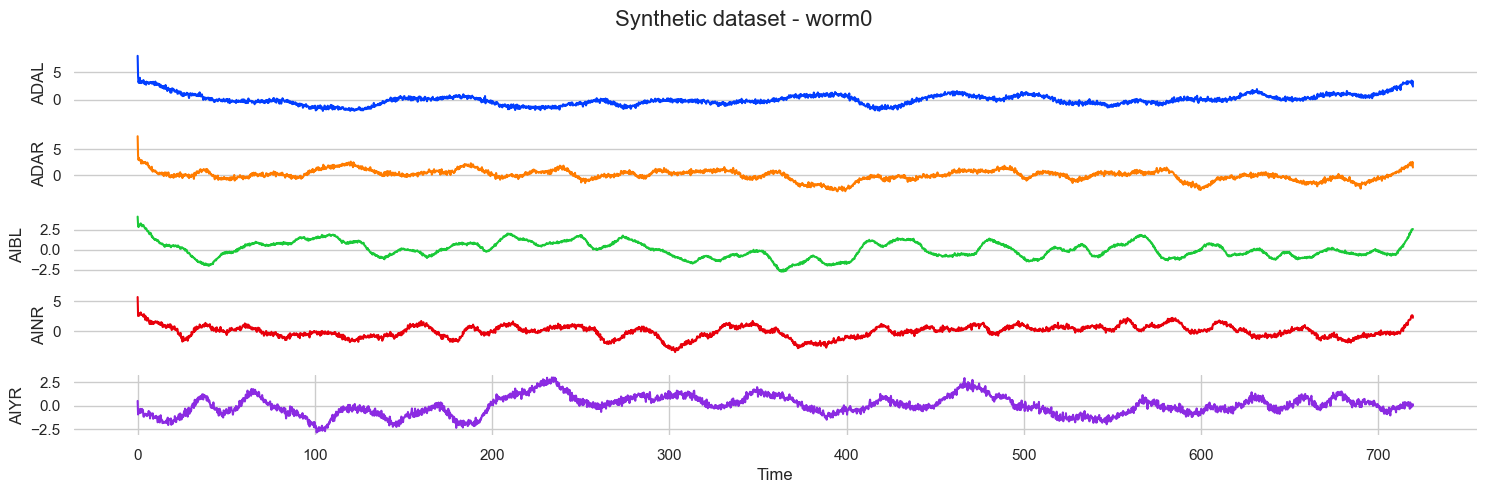

In [91]:
from tests.leandro.plots import plot_signals

worm_idx = "worm0"

neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()]
neuron_idx = neuron_idx[:5]

plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)

# Sine synthetic data
---

In [92]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset_sines(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                [
                    0.01,
                    0.02,
                ],  # [freq_gain * np.random.uniform(0, 0.025) for _ in range(sum_frequencies)], #! Modify here!
            )
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3000
num_worms = 1
num_signal = 302
num_named_neurons = 201
file_name = "Synthetic_sines"

# Creating and saving datasets
dataset = create_synthetic_dataset_sines(
    max_timesteps,
    num_worms,
    num_signal,
    num_named_neurons,
    if_noise=False,
    sum_frequencies=2,
    freq_gain=1.0,
    delta_seconds=0.25,
    noise_sd=0.00,
    transform=StandardScaler(),
    dataset_name=file_name,
)
save_synthetic_dataset(f"processed/neural/{file_name}.pickle", dataset)

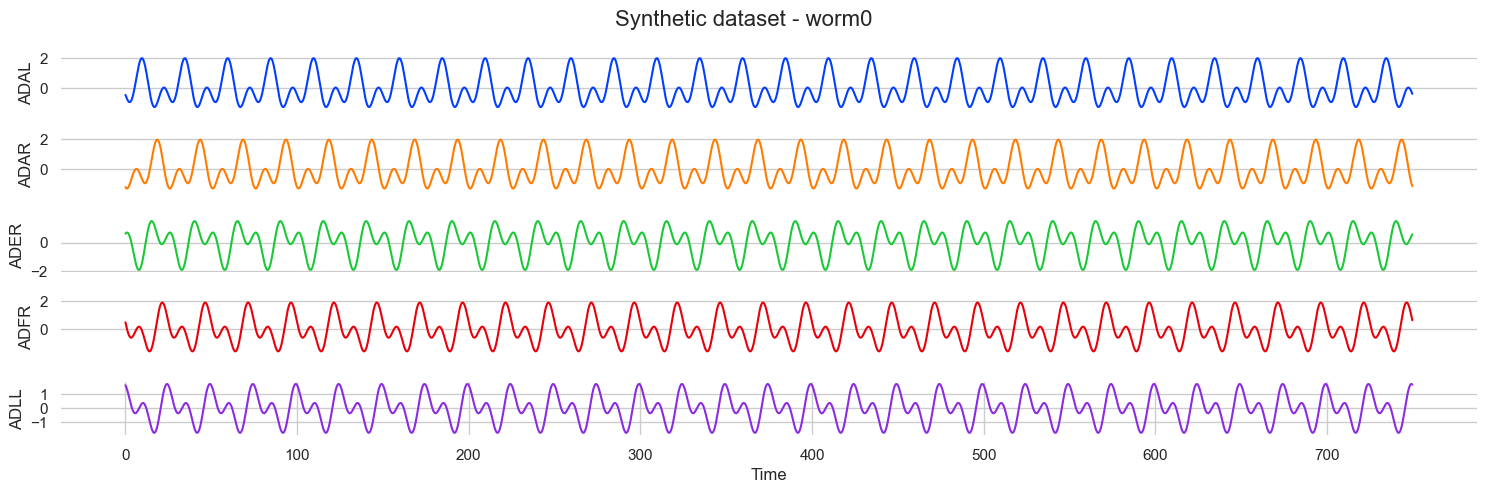

In [93]:
from tests.leandro.plots import plot_signals

worm_idx = "worm0"

neuron_idx = [idx for idx in dataset[worm_idx]["slot_to_neuron"].keys()]
neuron_idx = neuron_idx[:5]

plot_signals(
    data=dataset[worm_idx]["calcium_data"],
    time_tensor=dataset[worm_idx]["time_in_seconds"],
    neuron_idx=neuron_idx,
    yax_limit=False,
    suptitle="Synthetic dataset - {}".format(worm_idx),
)